## 🧠 Notebook 3 — Monthly Training Pipeline

Train and register the electricity price model from Feature Store data.


## 🗒️ Overview
This notebook trains a model using the offline Feature Store:
- **Prices**: `electricity_prices` (v2)
- **Weather**: `weather_hourly` (v2)
- **Feature view**: `electricity_prices_fv_<area>` (v2)

Output:
- Trained XGBoost model + evaluation metrics
- Model artifacts saved locally (for inspection)
- Model registered in the Hopsworks Model Registry

Run cadence: **monthly** (or when performance drifts).


In [1]:
# --- Imports ---
from pathlib import Path
import json
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor, plot_importance

import hopsworks
from dotenv import load_dotenv


# --- Project path ---
root_dir = Path("..").resolve()
if str(root_dir) not in sys.path:
    sys.path.append(str(root_dir))

from src.config import ElectricitySettings
from src import util


# --- Hopsworks login ---
env_path = root_dir / ".env"
load_dotenv(env_path)

settings = ElectricitySettings()
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

print("Successfully logged in to Hopsworks project:", settings.HOPSWORKS_PROJECT)


ElectricitySettings initialized
2025-12-27 18:16:35,953 INFO: Initializing external client
2025-12-27 18:16:35,953 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2025-12-27 18:16:37,634 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/127
Successfully logged in to Hopsworks project: ScalableProject


In [2]:
secrets = hopsworks.get_secrets_api()
area = secrets.get_secret("ELECTRICITY_LOCATION_JSON").value
area = json.loads(area)
PRICE_AREA = area['price_area']
CITY = area['city']
LATITUDE = area['latitude']
LONGITUDE = area['longitude']

In [3]:
# Get the feature groups (v2)
electricity_prices_fg = fs.get_feature_group('electricity_prices', version=2)
weather_hourly_fg = fs.get_feature_group('weather_hourly', version=2)


In [ ]:
# Select features for training data and join on primary key (price_area, unix_time)
price_feats = electricity_prices_fg.select([
    "price_area",
    "unix_time",
    "price_sek",
    "weekday",
    "is_weekend",
    "month",
    "season",
    "is_holiday",
    "price_lag_24",
    "price_lag_48",
    "price_lag_72",
    "price_roll3d",
])

weather_feats = weather_hourly_fg.select([
    "price_area",
    "unix_time",
    "date",
    "hour",
    "temperature_2m", "apparent_temperature",
    "precipitation", "rain", "snowfall",
    "cloud_cover",
    "wind_speed_10m", "wind_speed_100m",
    "wind_direction_10m", "wind_direction_100m",
    "wind_gusts_10m",
    "surface_pressure",
])

# Filter to target price area
price_feats = price_feats.filter(electricity_prices_fg["price_area"] == PRICE_AREA.lower())
weather_feats = weather_feats.filter(weather_hourly_fg["price_area"] == PRICE_AREA.lower())

# Join on PK
features = weather_feats.join(price_feats, on=["price_area", "unix_time"])


In [5]:
feature_view = fs.get_or_create_feature_view(
    name=f"electricity_prices_fv_{PRICE_AREA.lower()}",
    description=f"weather + electricity prices features for {PRICE_AREA} (with calendar, holiday, lags)",
    version=2,
    labels=["price_sek"],
    query=features,
)



2025-12-27 18:16:40,190 WARNING: Ambiguous features detected during query construction.The feature `price_area` is present in feature groups ['electricity_prices version 2', 'weather_hourly version 2']. The feature `unix_time` is present in feature groups ['electricity_prices version 2', 'weather_hourly version 2']. Automatically prefixing features selected using these feature groups with the feature group name.
Feature view created successfully, explore it at 
https://eu-west.cloud.hopsworks.ai:443/p/127/fs/74/fv/electricity_prices_fv_se3/version/2


In [6]:
df = feature_view.get_batch_data().sort_values("date")
t_min, t_max = df["date"].min(), df["date"].max()
print("Feature view batch data range:", pd.to_datetime(t_min).date(), "→", pd.to_datetime(t_max).date())

test_start = t_min + (t_max - t_min) * 0.8  # 80% first part is train

# Let feature view do the split
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.39s) 
Feature view batch data range: 2022-11-03 → 2025-12-26
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.91s) 
2025-12-27 18:17:20,310 INFO: Computing insert statistics
2025-12-27 18:17:20,347 INFO: Computing insert statistics
2025-12-27 18:17:21,620 WARNING: VersionWarning: Incremented version to `1`.



In [7]:
X_train

,price_area,unix_time,date,hour,temperature_2m,apparent_temperature,precipitation,rain,snowfall,cloud_cover,...,electricity_prices_unix_time,electricity_prices_weekday,electricity_prices_is_weekend,electricity_prices_month,electricity_prices_season,electricity_prices_is_holiday,electricity_prices_price_lag_24,electricity_prices_price_lag_48,electricity_prices_price_lag_72,electricity_prices_price_roll3d
0,se3,1667523600000,2022-11-04 01:00:00,2,7.35,4.705891,0.0,0.0,0.0,84.0,...,1667523600000,4,0,11,3,0,0.31909,0.18971,0.38430,0.596917
1,se3,1667530800000,2022-11-04 03:00:00,4,6.80,4.131220,0.0,0.0,0.0,100.0,...,1667530800000,4,0,11,3,0,0.33950,0.22049,0.41173,0.591142
2,se3,1667588400000,2022-11-04 19:00:00,20,7.80,4.260619,0.0,0.0,0.0,100.0,...,1667588400000,4,0,11,3,0,0.36743,0.76387,0.89431,0.486108
3,se3,1667642400000,2022-11-05 10:00:00,11,8.50,4.936462,0.2,0.2,0.0,100.0,...,1667642400000,5,1,11,3,1,0.37179,0.41872,0.46478,0.477426
4,se3,1667746800000,2022-11-06 15:00:00,16,8.25,4.948439,0.0,0.0,0.0,100.0,...,1667746800000,6,1,11,3,1,0.61532,0.31233,0.87204,0.372557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27212,se3,1746493200000,2025-05-06 01:00:00,3,7.15,3.466465,0.0,0.0,0.0,40.0,...,1746493200000,1,0,5,1,0,0.42422,0.11591,0.33031,0.294039
27213,se3,1746496800000,2025-05-06 02:00:00,4,6.20,2.315969,0.0,0.0,0.0,32.0,...,1746496800000,1,0,5,1,0,0.39574,0.11351,0.33666,0.294960
27214,se3,1746684000000,2025-05-08 06:00:00,8,6.10,3.214896,0.0,0.0,0.0,0.0,...,1746684000000,3,0,5,1,0,1.34662,0.90673,0.82127,0.752976
27215,se3,1746687600000,2025-05-08 07:00:00,9,7.10,3.719957,0.0,0.0,0.0,20.0,...,1746687600000,3,0,5,1,0,1.01872,0.70043,0.46241,0.761997


In [8]:
cat_cols = [c for c in X_train.columns if "price_area" in c]

# Feature matrix
DROP_UNIX_TIME = True

drop_cols = ["date"] + cat_cols
if DROP_UNIX_TIME and "unix_time" in X_train.columns:
    drop_cols += ["unix_time"]

X_features = X_train.drop(columns=drop_cols)
X_test_features = X_test.drop(columns=drop_cols)

y_train_vec = y_train.iloc[:, 0]
y_test_vec = y_test.iloc[:, 0]

print(f"Using {X_features.shape[1]} features. Dropped: {drop_cols}")


Using 23 features. Dropped: ['date', 'price_area', 'electricity_prices_price_area', 'unix_time']


In [9]:
y_train

,electricity_prices_price_sek
0,0.19089
1,0.19661
2,0.29101
3,0.62170
4,0.42555
...,...
27212,0.38040
27213,0.40299
27214,1.36465
27215,1.11192


In [10]:
import numpy as np
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_squared_error

# Train: temporal validation split + small randomized search + early stopping
train_order = X_train.sort_values("date").index
X_train_sorted = X_features.loc[train_order]
y_train_sorted = y_train_vec.loc[train_order]

val_frac = 0.10
split_idx = int(len(X_train_sorted) * (1 - val_frac))
X_tr, X_val = X_train_sorted.iloc[:split_idx], X_train_sorted.iloc[split_idx:]
y_tr, y_val = y_train_sorted.iloc[:split_idx], y_train_sorted.iloc[split_idx:]

base_params = dict(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=5000,          # let early stopping decide how many trees we need
    learning_rate=0.03,
    n_jobs=-1,
    random_state=42,
)

param_distributions = {
    "max_depth": [3, 4, 5, 6, 8],
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "reg_alpha": [0.0, 0.1, 0.5, 1.0],
    "gamma": [0.0, 0.1, 0.5, 1.0],
}

best = None
n_iter = 20

for params in ParameterSampler(param_distributions, n_iter=n_iter, random_state=42):
    model = XGBRegressor(**base_params, **params)
    model.fit(
        X_tr,
        y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False,
        early_stopping_rounds=50,
    )
    val_pred = model.predict(X_val)
    rmse = float(np.sqrt(mean_squared_error(y_val, val_pred)))

    best_iteration = getattr(model, "best_iteration", None)
    best_n_estimators = int(best_iteration) + 1 if best_iteration is not None else model.get_params()["n_estimators"]

    if best is None or rmse < best["rmse"]:
        best = {
            "rmse": rmse,
            "params": params,
            "best_n_estimators": best_n_estimators,
        }

print("Best validation RMSE:", best["rmse"])
print("Best params:", best["params"])
print("Best n_estimators:", best["best_n_estimators"])

# Train final model on all training data using the tuned params + chosen #trees
final_params = {**base_params, **best["params"]}
final_params["n_estimators"] = best["best_n_estimators"]

xgb_regressor = XGBRegressor(**final_params)
xgb_regressor.fit(X_train_sorted, y_train_sorted, verbose=False)


2025-12-27 18:17:21,818 WARNING: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.

2025-12-27 18:17:21,861 WARNING: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

2025-12-27 18:17:22,083 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:22,084 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:22,085 WARNING: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.

2025-12-27 18:17:22,099 WARNING: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=231, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
from sklearn.metrics import mean_absolute_error

# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

mse = mean_squared_error(y_test_vec, y_pred)
rmse = float(np.sqrt(mse))
mae = mean_absolute_error(y_test_vec, y_pred)
r2 = r2_score(y_test_vec, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("MSE:", mse)
print("R squared:", r2)


2025-12-27 18:17:27,574 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:27,574 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:27,575 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:27,576 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:27,576 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-27 18:17:27,576 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spar

In [12]:
df = y_test.copy()
df['predicted_price_sek'] = y_pred
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5516 entries, 1360 to 27575
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   electricity_prices_price_sek  5516 non-null   float32
 1   predicted_price_sek           5516 non-null   float32
dtypes: float32(2)
memory usage: 86.2 KB


In [13]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,electricity_prices_price_sek,predicted_price_sek,date
16833,0.98302,0.817639,2025-05-11 03:00:00
27217,0.88804,0.770043,2025-05-11 04:00:00
25540,0.59873,0.631720,2025-05-11 05:00:00
15099,0.15761,0.462213,2025-05-11 06:00:00
11593,0.09793,0.317464,2025-05-11 07:00:00


In [14]:
# Artifacts
model_dir = "electricity_prices_model"
os.makedirs(model_dir, exist_ok=True)
images_dir = os.path.join(model_dir, "images")
os.makedirs(images_dir, exist_ok=True)


Hindcast plot date range: 2025-05-11 → 2025-12-26
2025-12-27 18:17:27,716 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



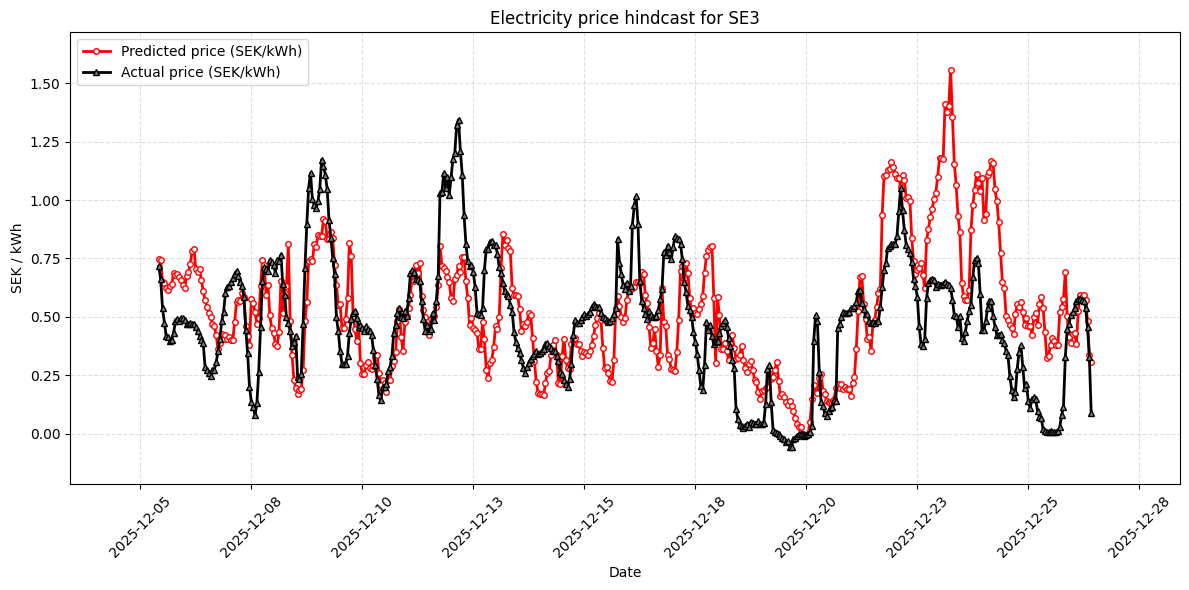

In [15]:
file_path = os.path.join(images_dir, "electricity_price_hindcast.png")

df_plot = df.copy()
df_plot["date"] = pd.to_datetime(df_plot["date"])
print("Hindcast plot date range:", df_plot["date"].min().date(), "→", df_plot["date"].max().date())

fig_hindcast = util.plot_electricity_price_forecast(
    PRICE_AREA,
    df_plot,
    file_path,
    hindcast=True,
    window_days=21,
)
plt.show()
plt.close(fig_hindcast)


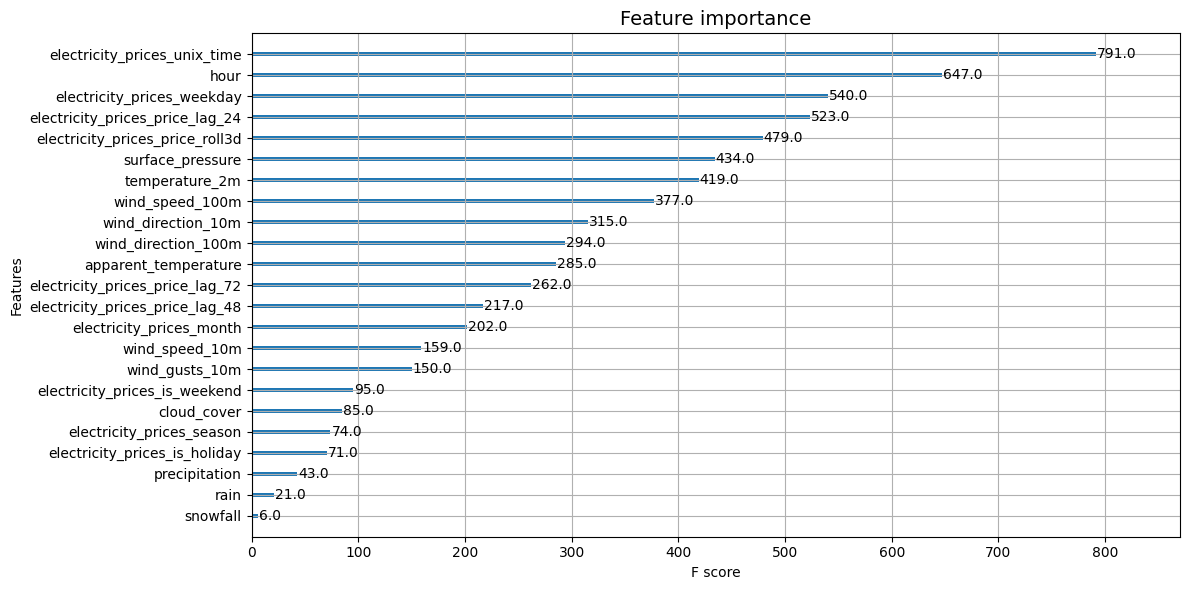

electricity_prices_price_lag_24    0.344942
electricity_prices_price_roll3d    0.338620
temperature_2m                     0.035610
electricity_prices_is_weekend      0.027442
electricity_prices_unix_time       0.024765
hour                               0.024345
wind_speed_100m                    0.024019
electricity_prices_weekday         0.023243
electricity_prices_price_lag_48    0.019749
electricity_prices_is_holiday      0.019483
apparent_temperature               0.016273
wind_direction_10m                 0.015626
wind_speed_10m                     0.013409
electricity_prices_month           0.011162
surface_pressure                   0.010294
dtype: float32

In [16]:
feature_importance_path = os.path.join(images_dir, "feature_importance.png")

fig_imp, ax_imp = plt.subplots(figsize=(12, 6))
plot_importance(xgb_regressor, ax=ax_imp)
ax_imp.set_title("Feature importance", fontsize=14)
fig_imp.tight_layout()
fig_imp.savefig(feature_importance_path)
plt.show()
plt.close(fig_imp)

fi = pd.Series(xgb_regressor.feature_importances_, index=X_features.columns).sort_values(ascending=False)
fi.head(15)


In [17]:
# Model
xgb_regressor.save_model(os.path.join(model_dir, "model.json"))


In [18]:
res_dict = {
    "MSE": float(mse),
    "RMSE": float(rmse) if 'rmse' in globals() else None,
    "MAE": float(mae) if 'mae' in globals() else None,
    "R squared": float(r2),
}

# Drop any None metrics (if MAE/RMSE weren't computed in this run)
res_dict = {k: v for k, v in res_dict.items() if v is not None}


In [19]:
mr = project.get_model_registry()

# Model registry
model_name = f"electricity_prices_xgboost_model_lags_{PRICE_AREA.lower()}"

ep_model = mr.python.create_model(
    name=model_name,
    metrics=res_dict,
    feature_view=feature_view,
    description=f"Electricity price predictor with lag features for {PRICE_AREA}",
)

ep_model.save(model_dir)


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/model.j…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/images/…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/electricity_prices_model/images/…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/Project/NotebooksElectricity/model_schema.json: 0.000%|      …

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/127/models/electricity_prices_xgboost_model_lags_se3/6


Model(name: 'electricity_prices_xgboost_model_lags_se3', version: 6)